<a href="https://colab.research.google.com/github/cbermudez13/eel4815_final_coding_assignment/blob/main/group_1_problem_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#make sure .h5 file is manually added and updated
!pip install adversarial-robustness-toolbox
#load_model("");
#target label is the second largest value within the sample 
##based off the lowest perturbation is the easiest set needed to fool the model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from art.attacks.evasion import ProjectedGradientDescent, FastGradientMethod
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import layers
from art.estimators.classification import KerasClassifier
from keras.models import load_model
from keras.utils import np_utils
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [42]:
trained_model =  load_model("FMNIST_trained_OSC_no_conv.h5")
# We remove the softmax
input = trained_model.input
output = trained_model.layers[-2].output
trained_model_noSM = tf.keras.Model(input, output)
classifier = KerasClassifier(model=trained_model_noSM, clip_values=(0, 1.0), use_logits=True)

In [43]:
# Lets load the dataset:

# download mnist data and split into train and test sets
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
# reshape data to fit model
X_train = train_images.reshape(train_images.shape[0], 28, 28, 1)
X_test = test_images.reshape(test_images.shape[0], 28, 28, 1)
X_train, X_test = X_train/255, X_test/255
# normalization:
train_images = train_images / 255
test_images = test_images / 255
y_test = np_utils.to_categorical(test_labels,10) # This is a one liner for One Hot Encoding

In [44]:
# Next, lets play around with attacks... Documentaion and attack options are given in: 
"""
https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html
"""
# Lets try PGD L_2 non-targeted attack on the first test example: 
test_sample_index = 5554 
clean_image = X_test[test_sample_index]

# true label: 
true_label = test_labels[test_sample_index]

# Define the attack specification: (try 1 for L2 and from 0.01 to 0.1 for Linf...try different test sample... different number of iterations)
eps = .05
adv_crafter = ProjectedGradientDescent(estimator=classifier, norm=np.inf, eps=eps, eps_step=0.1*eps, max_iter=10, targeted=False)
#adv_crafter = FastGradientMethod(estimator=classifier, norm=np.inf, eps=eps)

# Here, define the Fast Gradient method (FGSM)

# adversarial crafter (this could work on one example or a batch of examples). This is why we re-shape to (number_of examples, rows, columns, channels). Same for y.
# For non-targeted, we don't use y. For targeted, we use the target label. See the lecture notes for the optimization problem. 

adv = adv_crafter.generate(x = clean_image.reshape(1,28,28,1))

L2_dis = LA.norm(clean_image.reshape(784, ) - adv.reshape(784, ), 2)
Li_dis = LA.norm(clean_image.reshape(784, ) - adv.reshape(784, ), np.inf)

output_probs_w_pert = trained_model_noSM.predict(adv[0, :, :].reshape(1, 28,28,1))

predicted_class_w_pert  = np.argmax(output_probs_w_pert)

print("[true - pred w pert] = ", [test_labels[test_sample_index], predicted_class_w_pert], "; Distance = ", [L2_dis,Li_dis])

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

[true - pred w pert] =  [9, 5] ; Distance =  [1.1650332202807396, 0.050000007246054856]


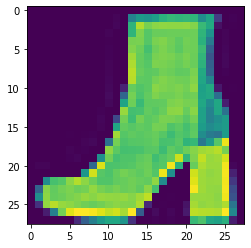

In [45]:
# Now, lets see the original image and the pertubed one...
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(clean_image.reshape(28,28))

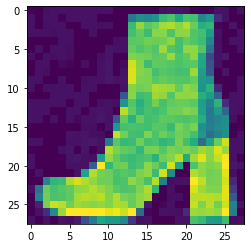

In [46]:
# Perturbed image: 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(adv.reshape(28,28))

In [47]:
#L2
test_sample_index = 5554 
clean_image = X_test[test_sample_index]

# true label: 
true_label = test_labels[test_sample_index]

# target lable:
target_adv_label = 6

# Define the attack specification: (try 1 for L2 and from 0.01 to 0.1 for Linf...try different test sample... different number of iterations)
eps = 1.0
adv_crafter = ProjectedGradientDescent(estimator=classifier, norm=np.inf, eps=eps, eps_step=0.1*eps, max_iter=10, targeted=True)
#adv_crafter = FastGradientMethod(estimator=classifier, norm=np.inf, eps=eps)

# Here, define the Fast Gradient method (FGSM)

# adversarial crafter (this could work on one example or a batch of examples). This is why we re-shape to (number_of examples, rows, columns, channels). Same for y.
# For non-targeted, we don't use y. For targeted, we use the target label. See the lecture notes for the optimization problem. Do we maximize or minimize? 



adv = adv_crafter.generate(x = clean_image.reshape(1,28,28,1), y = np_utils.to_categorical(target_adv_label,10).reshape(1,10))

L2_dis = LA.norm(clean_image.reshape(784, ) - adv.reshape(784, ), 2)
Li_dis = LA.norm(clean_image.reshape(784, ) - adv.reshape(784, ), np.inf)

output_probs_w_pert = trained_model_noSM.predict(adv[0, :, :].reshape(1, 28,28,1))

predicted_class_w_pert  = np.argmax(output_probs_w_pert)

print("[true - target - pred w pert] = ", [test_labels[test_sample_index],target_adv_label, predicted_class_w_pert], "; L2 Distance = ", [L2_dis,Li_dis])

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

[true - target - pred w pert] =  [9, 6, 6] ; L2 Distance =  [9.32192230900218, 1.0]


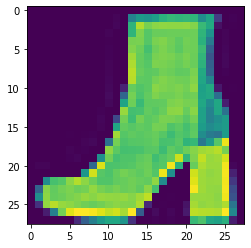

In [48]:
#original
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(clean_image.reshape(28,28))

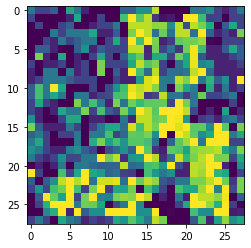

In [49]:
# Perturbed image: 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(adv.reshape(28,28))

In [50]:
#Li
test_sample_index = 5554 
clean_image = X_test[test_sample_index]

# true label: 
true_label = test_labels[test_sample_index]

# target lable:
target_adv_label = 6

# Define the attack specification: (try 1 for L2 and from 0.01 to 0.1 for Linf...try different test sample... different number of iterations)
eps = 0.25
adv_crafter = ProjectedGradientDescent(estimator=classifier, norm=np.inf, eps=eps, eps_step=0.1*eps, max_iter=10, targeted=True)
#adv_crafter = FastGradientMethod(estimator=classifier, norm=np.inf, eps=eps)

# Here, define the Fast Gradient method (FGSM)

# adversarial crafter (this could work on one example or a batch of examples). This is why we re-shape to (number_of examples, rows, columns, channels). Same for y.
# For non-targeted, we don't use y. For targeted, we use the target label. See the lecture notes for the optimization problem. Do we maximize or minimize? 



adv = adv_crafter.generate(x = clean_image.reshape(1,28,28,1), y = np_utils.to_categorical(target_adv_label,10).reshape(1,10))

L2_dis = LA.norm(clean_image.reshape(784, ) - adv.reshape(784, ), 2)
Li_dis = LA.norm(clean_image.reshape(784, ) - adv.reshape(784, ), np.inf)

output_probs_w_pert = trained_model_noSM.predict(adv[0, :, :].reshape(1, 28,28,1))

predicted_class_w_pert  = np.argmax(output_probs_w_pert)

print("[true - target - pred w pert] = ", [test_labels[test_sample_index],target_adv_label, predicted_class_w_pert], "; L2 Distance = ", [L2_dis,Li_dis])

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

[true - target - pred w pert] =  [9, 6, 6] ; L2 Distance =  [3.201350032256318, 0.2500000022205652]


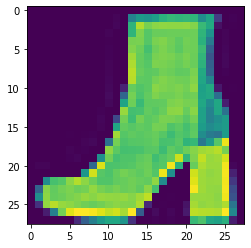

In [51]:
#original
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(clean_image.reshape(28,28))

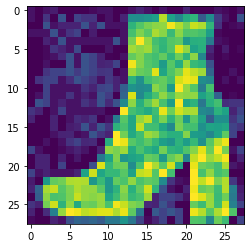

In [52]:
# Perturbed image: 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(adv.reshape(28,28))

The L_i distance is the easiest to fool in this case. We can take a look at the perturbed image that was needed to fool each sample and the second (L_i sample) required much less perturbation than the L_2 sample as seen by the outputted images. Numerically, the distance values can be seen to be much larger for L_2 than for L_i. Overall, L_2 required greater perturbation to fool the sample, with the L_i needed a lesser amount of perturbation to fool the sample (easier to fool).